In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv , os ,  tqdm , time , ssm , json
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pathlib import Path
from plotly import tools
from matplotlib import cm
from ARHMM_utils import *
from DataSnipper import DataSnipper
from sklearn.model_selection import train_test_split
from ARHMM_wo_test import fit_ARHMM

In [161]:
# Frans vid
#data_csv = r'c:\Users\magnu\OneDrive\Dokument\KI\KI2020\New_data_201120\Mouse_frans\20201120_behaviour2020_v_frans_1_pose_data.csv'
#vid_name = r'c:\Users\magnu\OneDrive\Dokument\KI\KI2020\New_data_201120\Mouse_frans\20201120_behaviour2020_v_frans_1_recordingDLC_resnet50_KI2020_TrainingSep19shuffle1_400000_labeled.mp4'
#dlc_csv = r'c:\Users\magnu\OneDrive\Dokument\KI\KI2020\New_data_201120\Mouse_frans\20201120_behaviour2020_v_frans_1_recordingDLC_resnet50_KI2020_TrainingSep19shuffle1_400000.csv'

# 2050 vid
data_csv = r'c:\Users\magnu\OneDrive\Dokument\KI\KI2020\New_data_201120\Mouse_2050\20201120_behaviour2020_v_2050_for_frans_1_pose_data.csv'
vid_name = r'c:\Users\magnu\OneDrive\Dokument\KI\KI2020\New_data_201120\Mouse_2050\20201120_behaviour2020_v_2050_for_frans_1_recording.avi'
dlc_csv = r'c:\Users\magnu\OneDrive\Dokument\KI\KI2020\New_data_201120\Mouse_2050\20201120_behaviour2020_v_2050_for_frans_1_recordingDLC_resnet50_KI2020_TrainingSep19shuffle1_400000.csv'

# 2053 vid
#data_csv = r'c:\Users\magnu\OneDrive\Dokument\KTH\2020HT\DD2430_-_Project_Course_in_Data_Science\sharing\New_data_201120\Mouse_2053\20201120_behaviour2020_v_2053_for_frans_1_pose_data.csv'
#vid_name = r'c:\Users\magnu\OneDrive\Dokument\KTH\2020HT\DD2430_-_Project_Course_in_Data_Science\sharing\New_data_201120\Mouse_2053\20201120_behaviour2020_v_2053_for_frans_1_recordingDLC_resnet50_KI2020_TrainingSep19shuffle1_400000_labeled.mp4'
#dlc_csv = r'c:\Users\magnu\OneDrive\Dokument\KTH\2020HT\DD2430_-_Project_Course_in_Data_Science\sharing\New_data_201120\Mouse_2053\20201120_behaviour2020_v_2053_for_frans_1_recordingDLC_resnet50_KI2020_TrainingSep19shuffle1_400000.csv'

#interval_start = 233694 - 220000
interval_start = 0
interval_end = 220000
div = 10

ARHMM_kwargs={  'kappa':2500,
                'use_best_K':True, 
                'K':11,
                'epochs':50,
                'start_K':1,
                'end_K':30}
threshold = 0.01

make_vid = True
smooth = True
box_size = 0.6
box_pixel = 400
T = 2e-3
d = 5
seed = 1337
early_stopping = True

In [162]:

timestr = time.strftime("%Y%m%d-%H%M%S")
p = os.path.normpath(data_csv)
newpath = os.sep.join([os.sep.join(p.split(os.sep)[:-1]), 'results',timestr])

Path(newpath).mkdir(parents=True, exist_ok=True)

kappa = ARHMM_kwargs['kappa']


data_frame2 = pd.read_csv(data_csv)

if interval_end in ['end',-1]:
    interval_end = len(data_frame2) - 1

interval = range(interval_start,interval_end)

# Preprocess data
data_to_use , df , speed , head_body_angle , body_len , outliers = preprocess_data(data_frame2, interval, div, smooth, box_size, box_pixel, d, T)

interval = np.linspace(interval_start + d,interval_end-len(outliers),len(speed))


Number of outliers removed: 38 (0.009295499021526418 %)


C:\Users\magnu\OneDrive\Dokument\KI\KI2020\Analysis\ARHMM_utils.py:94: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\magnu\OneDrive\Dokument\KI\KI2020\Analysis\ARHMM_utils.py:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [163]:


#¤¤ Produce ARHMM data! ¤¤¤
#best_hmm , best_train_lls , best_val_lls , best_K_AIC , best_K_ll , val_lls , train_lls , AIC
hmm , best_train_lls , best_val_lls , best_K , best_K_ll , val_lls , train_lls , AIC = produce_ARHMM_data(data_to_use, ARHMM_kwargs, seed, early_stopping=early_stopping,threshold=threshold)

hmm_z = hmm.most_likely_states(data_to_use,)


Early stopped at epoch  11


In [164]:
best_K

11

In [165]:
df = pd.DataFrame(data_to_use,columns=['speed','yaw','bl'])

In [166]:
df['states'] = hmm_z

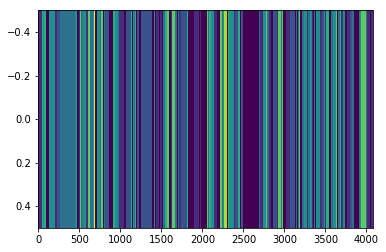

In [167]:
plt.imshow(hmm_z[None,],cmap='viridis',aspect='auto')

In [181]:
CL.unique

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [168]:
from matplotlib.colors import Normalize

df['state_consec'] = (df.states.diff(1) != 0).astype('int')

df['state_appearence'] = df.groupby('states')['state_consec'].cumsum()

CL = np.zeros((best_K,best_K))

for k in range(best_K):
    #print(k)
    N_k = df.loc[df['states'] == k]['state_appearence'].max()
    #print(N_k)
    
    if N_k is np.nan:
        continue
        
    for i in range(1,N_k):
        tmp_data = df.loc[(df['states'] == k) & (df['state_appearence'] == i)].values[:,:3]
        # N_k x K
        probs = hmm.filter(tmp_data)

        # Product over time to get sequence prob (1 x K)
        # Each col is p(data | theta_k) (i think)
        res = probs.prod(axis=0) + sys.float_info.min

        # This entry gives cross entropy between all states i=1,...,K and the true state k
        logprobs = np.log(res/res[k])
        CL[:,k] += logprobs / len(tmp_data)
      

Text(0, 0.5, 'Nats')

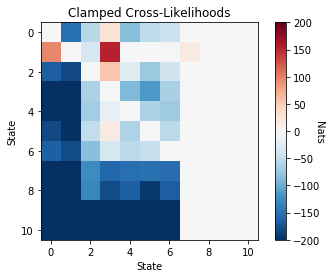

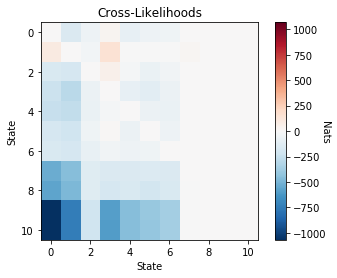

In [209]:
from matplotlib.colors import Normalize , LogNorm

# Create Truncated plot
CL_new = np.minimum(np.maximum(CL,-200),200)

min_val_CL = CL.min()
max_val_CL = CL.max()

min_val = CL_new.min()
max_val = CL_new.max()

max_mag = np.max([np.abs(CL_new.min()),np.abs(CL_new.max())])

min_val = -max_mag
max_val = max_mag

norm=Normalize(vmin=min_val, vmax=max_val)

fig , ax = plt.subplots(1,1)
im = ax.imshow(CL_new,norm=norm,cmap='RdBu_r')
cbar = fig.colorbar(im,ax=ax)
ax.set_title('Clamped Cross-Likelihoods')
ax.set_ylabel('State')
ax.set_xlabel('State')
cbar.ax.set_ylabel('Nats', rotation=270)
max_mag = np.max([np.abs(CL.min()),np.abs(CL.max())])

min_val = -max_mag
max_val = max_mag

norm2 = Normalize(vmin=min_val,vmax=max_val)

fig2 , ax = plt.subplots(1,1)
im = ax.imshow(CL,norm=norm2,cmap='RdBu_r')
cbar = fig2.colorbar(im,ax=ax)
ax.set_title('Cross-Likelihoods')
ax.set_ylabel('State')
ax.set_xlabel('State')
cbar.ax.set_ylabel('Nats', rotation=270)


In [223]:
hmm_new = [val if val in [1,2,3] for ]

C:\Users\magnu\anaconda3\envs\DLC-GPU\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



True

In [160]:
tmp_data

array([[ 0.07913858, -0.47921963,  0.05713078],
       [ 0.09702809, -1.44888511,  0.0551695 ]])

In [92]:
len(As)

20

In [94]:
As[0].dot(data_to_use[0]) + bs[0] + Vs[0]

array([ 0.07463442, -9.41598575,  0.05736902])

In [95]:
Vs[0]

array([], shape=(3, 0), dtype=float64)

In [96]:
Vs

array([], shape=(20, 3, 0), dtype=float64)

In [5]:
tll , vll , hmm2 = fit_ARHMM(train_data, val_data, obs_kwargs={'lags':10},num_states=5, epochs=5, transitions='sticky', transition_kwargs={'kappa':500},seed=1337,early_stopping=True,)

In [13]:
hmm2.observations.Vs

array([], shape=(5, 3, 0), dtype=float64)

In [108]:
from ssm.model_selection import cross_val_scores

In [14]:
hmm2.fit(train_data, method='em',num_iters=10,initialize=False,verbose=1)

[16167.002451372224,
 16169.660251223617,
 16298.697023636432,
 16396.580775974133,
 16469.945305945625,
 16505.943282076572,
 16532.52879129245,
 16551.734864441325,
 16562.937557976977,
 16566.663343427375,
 16570.67384725511]

In [30]:
hmm2.params

((array([-7.03714734e+00, -9.92012072e-04, -1.10322581e+01, -9.24380422e+00,
         -1.83962958e+01]),),
 (array([[-3.06973397e-02, -3.64437025e+00, -5.74247521e+00,
          -7.02848338e+00, -3.68406947e+01],
         [-3.82455299e+00, -3.03886432e-02, -5.79481329e+00,
          -5.39958247e+00, -7.52099420e+00],
         [-4.65019037e+00, -4.61918617e+00, -2.33230200e-02,
          -5.67302035e+00, -8.54213336e+00],
         [-5.00828882e+00, -5.19787716e+00, -5.45890710e+00,
          -1.78483270e-02, -6.70794902e+00],
         [-2.10689270e+01, -6.29438704e+00, -3.68280982e+01,
          -6.29134587e+00, -3.70576480e-03]]),),
 (array([[[ 8.03118865e-01, -2.45002960e-04, -1.53188395e+00,
           -9.66001873e-02,  4.41424775e-04,  4.95296361e+00,
           -5.53606133e-02, -5.26664036e-04, -6.02384014e+00,
            9.08044575e-03,  6.24240542e-04,  4.19604935e+00,
            2.98011567e-02, -3.55908641e-04, -2.37887617e+00,
           -3.56372005e-02, -2.13167351e-04,  9.5

In [31]:
hmm2.observations.params

(array([[[ 8.03118865e-01, -2.45002960e-04, -1.53188395e+00,
          -9.66001873e-02,  4.41424775e-04,  4.95296361e+00,
          -5.53606133e-02, -5.26664036e-04, -6.02384014e+00,
           9.08044575e-03,  6.24240542e-04,  4.19604935e+00,
           2.98011567e-02, -3.55908641e-04, -2.37887617e+00,
          -3.56372005e-02, -2.13167351e-04,  9.57888689e-01,
           3.63962174e-02,  4.29320564e-04, -2.78512753e-01,
           4.15942382e-03, -4.95602407e-04,  1.26929625e+00,
           3.19553503e-02,  4.96807504e-04, -1.34862458e+00,
          -1.71343887e-02, -2.22794709e-04,  1.66142495e-01],
         [ 3.74391897e+00,  1.83619304e+00, -1.17738718e+02,
          -4.17252439e+00, -1.13118334e+00,  1.50931471e+02,
          -3.84366344e+00,  2.89073579e-01, -2.71410868e+02,
          -2.43634238e+00, -1.45169660e-02,  5.44760362e+02,
           6.43429724e+00,  2.17893500e-02, -4.59203609e+02,
          -2.39912053e+00, -1.09156264e-01,  1.31558392e+02,
          -3.83025559e+

In [39]:
hmm2.log_likelihood(train_data)

16634.54294531979

In [34]:
hmm2.init_state_distn.initial_state_distn

array([8.78629424e-04, 9.99008480e-01, 1.61715330e-05, 9.67089872e-05,
       1.02468471e-08])

In [35]:
hmm2.log_probability(train_data)

16581.56139794502

In [41]:
hmm2.__dict__

{'K': 5,
 'D': 3,
 'M': 0,
 'init_state_distn': <ssm.init_state_distns.InitialStateDistribution at 0x2d948f26ec8>,
 'transitions': <ssm.transitions.StickyTransitions at 0x2d948f26a88>,
 'observations': <ssm.observations.AutoRegressiveObservations at 0x2d948f26d88>}

In [44]:
hmm2.observations.params

(array([[[ 8.03118865e-01, -2.45002960e-04, -1.53188395e+00,
          -9.66001873e-02,  4.41424775e-04,  4.95296361e+00,
          -5.53606133e-02, -5.26664036e-04, -6.02384014e+00,
           9.08044575e-03,  6.24240542e-04,  4.19604935e+00,
           2.98011567e-02, -3.55908641e-04, -2.37887617e+00,
          -3.56372005e-02, -2.13167351e-04,  9.57888689e-01,
           3.63962174e-02,  4.29320564e-04, -2.78512753e-01,
           4.15942382e-03, -4.95602407e-04,  1.26929625e+00,
           3.19553503e-02,  4.96807504e-04, -1.34862458e+00,
          -1.71343887e-02, -2.22794709e-04,  1.66142495e-01],
         [ 3.74391897e+00,  1.83619304e+00, -1.17738718e+02,
          -4.17252439e+00, -1.13118334e+00,  1.50931471e+02,
          -3.84366344e+00,  2.89073579e-01, -2.71410868e+02,
          -2.43634238e+00, -1.45169660e-02,  5.44760362e+02,
           6.43429724e+00,  2.17893500e-02, -4.59203609e+02,
          -2.39912053e+00, -1.09156264e-01,  1.31558392e+02,
          -3.83025559e+

In [46]:
res = hmm2.filter(train_data[:10])

In [47]:
res.shape

(10, 5)

In [57]:
np.log(res[0]/res[1]).sum()/10

-2.3201085426156816

In [63]:
hmm2.most_likely_states(train_data)

array([1, 1, 1, ..., 0, 0, 0])

In [61]:
df = pd.DataFrame(train_data,columns=['speed','yaw','bl'])

In [62]:
df

,speed,yaw,bl
0,0.106955,-9.971930,0.057102
1,0.110504,-14.377134,0.058410
2,0.108359,-19.472044,0.059020
3,0.095086,-22.816790,0.058169
4,0.099718,-22.789645,0.056445
...,...,...,...
2853,0.015785,0.654214,0.049863
2854,0.006008,0.626518,0.049545
2855,0.005138,1.433516,0.049305
2856,0.007924,1.953950,0.049367
